In [1]:
from flygym.mujoco.arena.food_sources import FoodSource
from flygym.mujoco.arena.food_environment import OdorArenaEnriched
import numpy as np
import os
from pathlib import Path
import logging
import random
from tqdm import trange
from flygym.mujoco.arena import OdorArenaEnriched, change_rgba
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from flygym.mujoco import Parameters
from flygym.mujoco.examples.turning_controller import HybridTurningNMF


# Odor source: array of shape (num_odor_sources, 3) - xyz coords of odor sources
sources = [
    FoodSource([24, 0, 1.5], [1, 3], 12, change_rgba([255, 127, 14, 1])),
    FoodSource([8, -4, 1.5], [3, 7], 10, change_rgba([31, 119, 180, 1])),
    FoodSource([16, 4, 1.5], [2, 6], 10, change_rgba([255, 192, 203, 1])),
    FoodSource([12, -8, 1.5], [5, 3], 17, change_rgba([255, 0, 0, 1])),
    FoodSource([20, 3, 1.5], [9, 3], 20, change_rgba([0, 255, 0, 1])),
]

logging.basicConfig(level=logging.INFO)

In [2]:
# Set up the arena
arena = OdorArenaEnriched(
    food_sources=sources,
    size=(50, 50),
    diffuse_func=lambda x: x**-2,
    marker_size=0.3,
    key_angle=True,  # we add this boolean so that we compute the key for the valence dictionary by using the angle formed in the complex plane
)
# Add the NeuroMechFLy
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]
sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.5,
    render_window_size=(800, 608),
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False,
    render_camera="birdeye_cam",
)
sim = HybridTurningNMF(
    sim_params=sim_params,
    arena=arena,
    spawn_pos=(0, 0, 0.2),
    contact_sensor_placements=contact_sensor_placements,
    simulation_time=140,
)

In [3]:
help(sim.add_source)

Help on method add_source in module flygym.mujoco.examples.turning_controller:

add_source(new_source) method of flygym.mujoco.examples.turning_controller.HybridTurningNMF instance



(-0.5, 799.5, 607.5, -0.5)

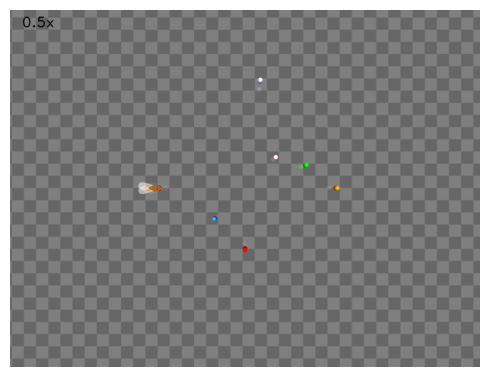

In [3]:
# sim.add_source(FoodSource([15, 10, 1.5], [6, 3], 8, change_rgba([15, 145, 67, 1])))
sim.add_source()

for i in range(100):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")
# fig.savefig("./outputs/olfaction_env.png")

(-0.5, 799.5, 607.5, -0.5)

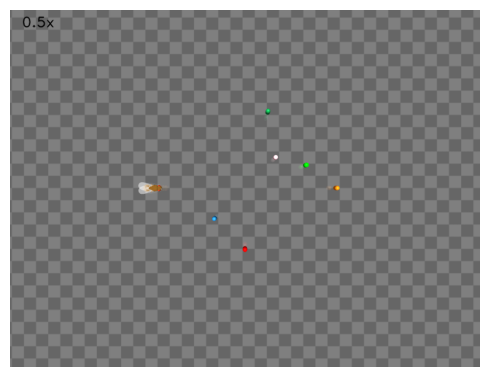

In [5]:
sim.arena.move_source(1, [0, 0, 1.5])
for i in range(1):
    sim.step(np.zeros(2))
    sim.render()
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.imshow(sim._frames[-1])
ax.axis("off")

In [3]:
# Let's start the simulation
decision_interval = 0.01
run_time = 40  # sim.simulation_time / 2
num_decision_steps = int(run_time / decision_interval)
logging.info("Number of decision steps: ", num_decision_steps)
physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)
logging.info("Physics steps per decision step: ", physics_steps_per_decision_step)

obs_hist = []
odor_history = []
obs, _ = sim.reset()

# Let's choose the source towards which the fly will walk
source = sim.choose_odor_exploration()
prev_reward = None
logging.info("Going to the source ", source + 1)

# Let's start the exploration
for i in trange(num_decision_steps):
    # compute the control signal to go towards the chosen source
    control_signal = arena.generate_specific_turning_control(source, sim)
    for _ in range(physics_steps_per_decision_step):
        obs, reward, terminated, truncated, _ = sim.step(control_signal, False, True)
        rendered_img = sim.render()
        if rendered_img is not None:
            # record odor intensity too for video
            odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)

        if reward != None:
            # let's check if the fly has actually reached a new source
            if prev_reward != reward:
                print(reward)
                # if it has, the sim.odor_scores, sim.key_odor_scores are updated and a new source to be reached is computed
                sim.update_odor_scores(source)
                sim.update_odor_scores_key(source)
                source = sim.choose_odor_exploration()
                logging.info("new source", source + 1)
                logging.info(sim.odor_scores)
                prev_reward = reward
        if terminated:
            logging.info("Out of time")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break
        if truncated:
            logging.info("No food source was reached, simulation is truncated")
            logging.info("Elapsed time in the simulation", sim.curr_time)
            break

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 10/4000 [00:14<1:33:45,  1.41s/it]


PhysicsError: Physics state is invalid. Warning(s) raised: mjWARN_BADQACC

In [3]:
# Let's check the confidence level for the fly's memory related to the different sources
print(sim.odor_scores)
# Let's check the fly's memory
print(sim.fly_valence_dictionary)
# Let's check the confidence level for the fly's memory related to the different smells
print(sim.key_odor_scores)

[0. 0. 0. 0. 0.]
{}
{0.32175055439664224: 0, 0.4048917862850834: 0, 1.0303768265243125: 0, 1.2490457723982544: 0}


In [27]:
# Choose a name to save both the video and the trajectory
name = "food_source_implementation"
path = Path(f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}")
# os.mkdir(path)

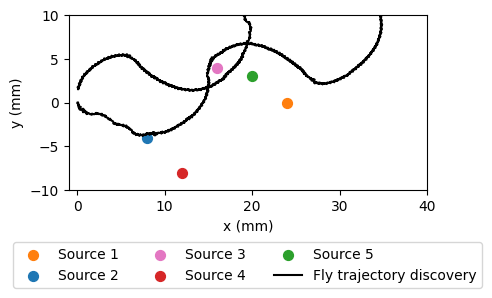

In [28]:
# Plot the trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(
    [arena.odor_source[0, 0]],
    [arena.odor_source[0, 1]],
    marker="o",
    color="tab:orange",
    s=50,
    label="Source 1",
)
ax.scatter(
    [arena.odor_source[1, 0]],
    [arena.odor_source[1, 1]],
    marker="o",
    color="tab:blue",
    s=50,
    label="Source 2",
)
ax.scatter(
    [arena.odor_source[2, 0]],
    [arena.odor_source[2, 1]],
    marker="o",
    color="tab:pink",
    s=50,
    label="Source 3",
)
ax.scatter(
    [arena.odor_source[3, 0]],
    [arena.odor_source[3, 1]],
    marker="o",
    color="tab:red",
    s=50,
    label="Source 4",
)
ax.scatter(
    [arena.odor_source[4, 0]],
    [arena.odor_source[4, 1]],
    marker="o",
    color="tab:green",
    s=50,
    label="Source 5",
)
ax.plot(
    fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Fly trajectory discovery"
)
ax.set_aspect("equal")
ax.set_xlim(-1, 40)
ax.set_ylim(-10, 10)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory.png"
)

In [29]:
# save the video
sim.save_video(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_video_exploration.mp4"
)

In [22]:
# In order for the fly to walk around the arena based on its internal state, it must have visited all the sources before
if not (sim.all_sources_explored()):
    # The fly is respawned
    obs, _ = sim.respawn()
    # Let the exploration begin
    decision_interval = 0.01
    run_time = sim.simulation_time / 2
    num_decision_steps = int(run_time / decision_interval)
    logging.info("Number of decision steps: ", num_decision_steps)
    physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)
    logging.info("Physics steps per decision step: ", physics_steps_per_decision_step)

    _obs_hist = []
    _odor_history = []

    # Bool to see if simulation is done
    sim_end = False
    # Get fly's hunger state
    hunger_limits = sim.food_requirements
    # To keep track of the previous internal state
    prev_int_state = ""

    prev_reward = None
    source = None

    # Run simulation
    # For each decision step
    for i in trange(num_decision_steps):
        if not (sim_end):
            # Check where the fly's hunger level is at
            int_state = sim.compute_internal_state()
            # Decide which source to go to based on the internal state
            if int_state == "starving":
                # the fly will reach the closest source
                source = sim.compute_closest_source(obs, True)
            elif int_state == "hungry":
                # the fly will reach the smell that has the highest reward
                # the fly chooses the closest source of this smell to go to
                source = sim.arena.compute_richest_closest_source(obs, True)
            else:
                if source == None:
                    # the fly will decide which source to go to based on its internal table
                    source = sim.choose_angle_key_odor_exploration()

            control_signal = sim.arena.generate_specific_turning_control(source, sim)
            # Make environment step and reward fly if it gets to a food source
            for _ in range(physics_steps_per_decision_step):
                obs, reward, terminated, truncated, _ = sim.step(
                    control_signal, False, True
                )
                rendered_img = sim.render(True)
                if rendered_img is not None:
                    # record odor intensity too for video
                    _odor_history.append(obs["odor_intensity"])
                _obs_hist.append(obs)

                # If fly gets to food source, simulation does not end
                # fly keeps walking based on its internal state
                if reward != None:
                    if prev_reward != reward:
                        # sim_end = True
                        # if it has, the sim.odor_scores, sim.key_odor_scores are updated and a new source to be reached is computed
                        sim.update_odor_scores_key(source)
                        source_reward = sim.compute_closest_source(obs)
                        sim.arena.move_
                        logging.info("Fly got to food source", source_reward)
                        logging.info("Elapsed time in the simulation", sim.curr_time)
                        prev_reward = reward
                        print(reward)
                        source = None
                        sim.add_new_source()
                        sim.arena.move_source(source)
                        break
                    # break
                # If fly has no food left, end simulation (death)
                # if obs["food_stocked"] < 0:
                #    sim_end = True
                #    logging.info("Fly died")
                #    break

                # If simulation should be terminated or truncted, end simulation
                if terminated:
                    logging.info("Out of time")
                    logging.info("Elapsed time in the simulation", sim.curr_time)
                    sim_end = True
                    break
                if truncated:
                    logging.info("No food source was reached, simulation is truncated")
                    logging.info("Elapsed time in the simulation", sim.curr_time)
                    sim_end = True
                    break

5.0


100%|██████████| 500/500 [00:00<00:00, 206840.12it/s]


In [ ]:
# Plot the trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in _obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
colors = cm.rainbow(np.linspace(0, 1, len(sim.arena.food_sources)))
for element in range(len(sim.arena.food_sources)):
    ax.scatter(
        [sim.arena.food_sources[element].position[0]],
        [sim.arena.food_sources[element].position[1]],
        marker="o",
        color=colors[element],
        s=50,
        label="Source" + str(element),
    )
ax.plot(
    fly_pos_hist[:, 0],
    fly_pos_hist[:, 1],
    color="k",
    label="Fly trajectory exploration",
)
ax.set_aspect("equal")
ax.set_xlim(-10, 50)
ax.set_ylim(-10, 50)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory_respawn.png"
)

In [ ]:
# Save the video
sim.save_video(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_video_respawn_internal_state.mp4"
)

In [ ]:
# Plot the trajectory
fly_pos_hist = np.array([obs["fly"][0, :2] for obs in obs_hist])
_fly_pos_hist = np.array([obs["fly"][0, :2] for obs in _obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
colors = cm.rainbow(np.linspace(0, 1, len(sim.arena.food_sources)))
for element in range(len(sim.arena.food_sources)):
    ax.scatter(
        [sim.arena.food_sources[element].position[0]],
        [sim.arena.food_sources[element].position[1]],
        marker="o",
        color=colors[element],
        s=50,
        label="Source" + str(element),
    )
ax.plot(fly_pos_hist[:, 0], fly_pos_hist[:, 1], color="k", label="Discovering phase")
ax.plot(_fly_pos_hist[:, 0], _fly_pos_hist[:, 1], color="r", label="Exploration phase")
ax.set_aspect("equal")
ax.set_xlim(-10, 50)
ax.set_ylim(-10, 50)
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.legend(ncols=3, loc="lower center", bbox_to_anchor=(0.5, -0.6))
fig.savefig(
    f"/home/nmf-learning/flygym-scratch/outputs/plots/{name}/odor_taxis_trajectory_respawn.png"
)